In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.autograd as autograd
import torchvision
from google.protobuf import text_format
import onnx
import numpy as np
import os
from onnx_tf.backend import run_model
from matplotlib import pyplot as plt
%matplotlib inline
# https://www.cs.toronto.edu/~kriz/cifar.html

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=2)
        self.fc1 = nn.Linear(720, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 720)
        x = F.relu(self.fc1(x))
        return F.softmax(x, dim=1)

In [4]:
model = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True,
                                        transform=transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.1307,), (0.3081,))
                                        ]))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

for epoch in range(1):  # loop over the dataset multiple times
  running_loss = 0.0
  for i, data in enumerate(trainloader):

    # get the inputs
    inputs, labels = data

    # wrap them in Variable
    inputs, labels = Variable(inputs), Variable(labels)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)

    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.data[0]
    if i % 2000 == 1999:  # print every 2000 mini-batches
      print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0
torch.onnx.export(model, dummy_input, "pb/torch_gh.pb", verbose=True, export_params=True)

Files already downloaded and verified


/Users/wenhao/.virtualenvs/ml_py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[1,  2000] loss: 2.301
[1,  4000] loss: 2.278
[1,  6000] loss: 2.228
[1,  8000] loss: 2.197
[1, 10000] loss: 2.170
[1, 12000] loss: 2.162
graph(%0 : Float(1, 3, 32, 32)
      %1 : Float(10, 3, 3, 3)
      %2 : Float(10)
      %3 : Float(20, 10, 5, 5)
      %4 : Float(20)
      %5 : Float(10, 720)
      %6 : Float(10)) {
  %7 : Float(1, 10, 15, 15) = Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[0, 0, 0, 0], strides=[2, 2]](%0, %1, %2), scope: Net/Conv2d[conv1]
  %8 : Float(1, 10, 15, 15) = Relu(%7), scope: Net
  %9 : Float(1, 20, 6, 6) = Conv[dilations=[1, 1], group=1, kernel_shape=[5, 5], pads=[0, 0, 0, 0], strides=[2, 2]](%8, %3, %4), scope: Net/Conv2d[conv2]
  %10 : Float(1, 20, 6, 6) = Relu(%9), scope: Net
  %11 : Float(1, 720) = Reshape[shape=[-1, 720]](%10), scope: Net
  %12 : Float(1, 10) = Gemm[alpha=1, beta=1, broadcast=1, transB=1](%11, %5, %6), scope: Net/Linear[fc1]
  %13 : Float(1, 10) = Relu(%12), scope: Net
  %14 : Float(1, 10) = Softmax[axis=1](%13), scope:

In [5]:
data = np.random.randn(1, 3, 32, 32).astype(np.float32)

In [6]:
img = np.transpose(np.squeeze(data), (1, 2, 0))
img = (img - np.min(img)) / (np.max(img) - np.min(img))

In [13]:
input = Variable(torch.from_numpy(data))
model(input)


 0.0553  0.1400  0.0893  0.1770  0.0930  0.0553  0.0553  0.1851  0.0553  0.0942
[torch.FloatTensor of size (1,10)]

In [30]:
with open(os.path.join('pb/torch_gh.pb'), "rb") as f:
    test = onnx.load(f)
    # data = np.transpose(data, (0, 2, 3, 1))
    rs_onnx = run_model(test, [data])
    print(rs_onnx)

/Users/wenhao/Projects/onnx-tensorflow/onnx_tf/backend.py:708: UserWarning: Unsupported kernel_shape attribute by Tensorflow in Conv operator. The attribute will be ignored.
  UserWarning)


Outputs(_0=array([[0.05534104, 0.14000303, 0.0893212 , 0.17703971, 0.09296753,
        0.05534104, 0.05534104, 0.18508212, 0.05534104, 0.09422229]],
      dtype=float32))


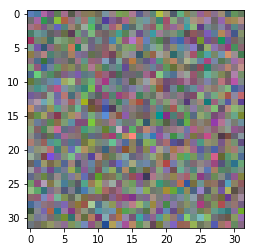

In [29]:
plt.imshow(img)